In [11]:
pip install osqp


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scipy-1.11.4-cp310-cp310-macosx_12_0_arm64.whl.metadata (112 kB)
  Using cached qdldl-0.1.7.post2-cp310-cp310-macosx_10_9_universal2.whl
Using cached scipy-1.11.4-cp310-cp310-macosx_12_0_arm64.whl (29.8 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for osqp (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [183 lines of output]
      Disabling LONG
      Remove long integers for numpy compatibility. See:
       - https://github.com/numpy/numpy/issues/5906
       - https://github.com/ContinuumIO/anaconda-issues/issues/3823
      You can reenable long integers by passing: --osqp --long argument.
      
      running bdist_wheel
      running 

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

from linear_solver import UOT_W
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn

import torch
from scipy.linalg import sqrtm


ModuleNotFoundError: No module named 'cvxpy'

# Figure 3: Illustration with the fragmented hypercube example (part of the implementation comes from POT)

In [ ]:
# parameters and data generation (from POT)

np.random.seed(42)
dim = 2
n = 20 * dim  # nb samples

xs = (np.random.rand(n, dim) - .5)*2
xt = (np.random.rand(n, dim) - .5)
xt = xt + 2*np.sign(xs)
xt2 = (np.random.rand(n, dim) - .5)
xt[:,2:] = xt2[:,2:]
# add 2 outliers
xt[-1,:] = 0
xt[-2,0] = -2
xt[-2,1] = 0
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

In [430]:
M = ot.dist(xs, xt)
G0 = ot.emd(a, b, M)


C = ot.dist(xs,xt)
overall_p = 2

X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

Cx,Cy = torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t,b_t = torch.ones((n,))/n, torch.ones((n,))/n

#factored coupling, with 4 hubs
Ga, Gb, xb = ot.factored_optimal_transport(xs, xt, a, b, r=4)

#partial OT
Pot = ot.partial.partial_wasserstein(a,b,C, (n-2)/n)

# exact OT with OT penalty (exact solver)
P, Qx, Qy = UOT_W(a_t, b_t, C, lam=4/n*4, Cx=Cx, Cy=Cy, solver="CLARABEL", innerplan = True)
a_W = P@np.ones(n)
b_W = (P.T)@np.ones(n)


#delete samples from the P matrix that have low mass
threshold = 1/(2*n)
sketches_x = np.sum(P, axis=1) 
sketches_x[sketches_x < threshold] = 0
sketches_y = np.sum(P, axis=0) 
sketches_y[sketches_y < threshold] = 0

#  OT with OT penalty (sinkhorn solver)
M = ot.dist(X, Y)
P_s, Qx_s, Qy_s = logsinkhorn(a_t, b_t, M, lam=.2/n*4, eps2=.1, eps= .1, numiter=30, pen="sinkhorn", Cx = ot.dist(X, X), Cy = ot.dist(Y, Y), numiter2=10, innerplan=True)

threshold = 0.08
sketches_x_s = np.sum(P_s.numpy(), axis=1) 
sketches_x_s[sketches_x_s < threshold] = 0
sketches_y_s = np.sum(P_s.numpy(), axis=0) 
sketches_y_s[sketches_y_s < threshold] = 0

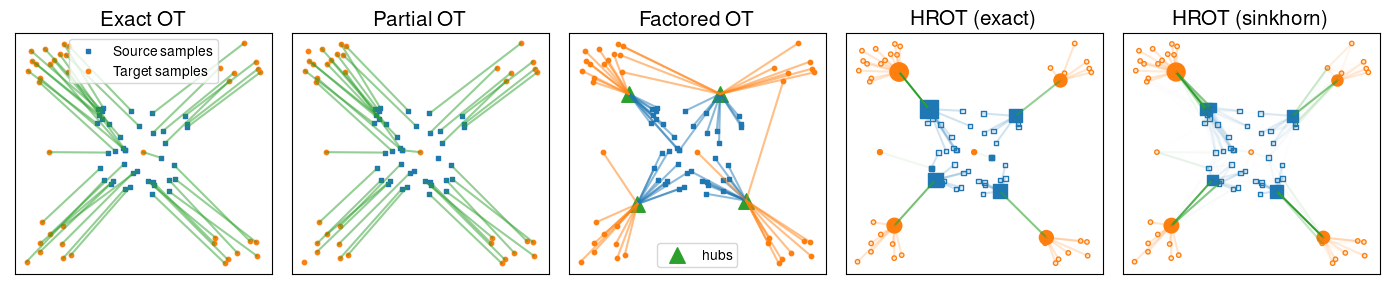

In [431]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
pl.figure(2, (14, 3))

s2 = 10
s = 500

#-------Exact OT
pl.subplot(3, 2, 1)
ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Exact OT',  fontsize = 15)

#-------L1 penalty
pl.subplot(3, 2, 2)
ot.plot.plot2D_samples_mat(xs, xt, Pot,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('Partial OT', fontsize = 15)

#-------Factored OT
pl.subplot(3, 2, 3)
ot.plot.plot2D_samples_mat(xs, xb, Ga, c='C0', alpha=0.5)
ot.plot.plot2D_samples_mat(xb, xt, Gb, c='C1', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2)
pl.scatter(xb[:, 0], xb[:, 1], c='C2',s=int(500/4), label='hubs', marker="^")
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Factored OT',  fontsize = 15)

#-------LOT 
s2 = 10
s = 500
n_source_anchors = 4
n_target_anchors = 4
eps = 5
from lot import LOT

lot = LOT(n_source_anchors= n_source_anchors, n_target_anchors= n_target_anchors, epsilon=eps, epsilon_z=eps)
lot.fit(xs, xt)
lot.Cx.shape, lot.Cy.shape, lot.Px_
print(lot.Py_.shape)
print(lot.Cx.shape)
print(lot.Cx)

ot.plot.plot2D_samples_mat(lot.Cx, lot.Cy, lot.Pz_, c='C2')
ot.plot.plot2D_samples_mat(xs, lot.Cx, lot.Px_, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, lot.Cy, lot.Py_.T, c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], facecolor=None, edgecolors='C0',label="$\mu_1$",s=s, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolor=None, edgecolors='C1',label="$\mu_2$",s=s)
pl.scatter(lot.Cx[:, 0], lot.Cx[:, 1],  c='C2',label="$\mu_1$",s=s2, marker="^")
pl.scatter(lot.Cy[:, 0], lot.Cy[:, 1], c='C3',label="$\mu_2$",s=s2, marker="^")
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('Latent OT',  fontsize = 15)


#-------HROT (exact solver)
pl.subplot(3, 2, 5)
ot.plot.plot2D_samples_mat(xs, xt, P, c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=sketches_x*s, marker= "s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=sketches_y*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (exact)',  fontsize = 15)


#-------HROT (sinkhorn)
pl.subplot(3, 2, 6)
ot.plot.plot2D_samples_mat(xs, xt, P_s.numpy(), c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx_s.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy_s.numpy(), c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1],  edgecolors='C0',label="$\mu_1$",s=sketches_x_s*s, marker="s")
pl.scatter(xt[:, 0], xt[:, 1],  edgecolors='C1',label="$\mu_2$",s=sketches_y_s*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (sinkhorn)',  fontsize = 15)


pl.savefig("comp_with_factored_couplings.pdf",bbox_inches='tight')




/Users/lchapel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lchapel/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(6, 40)
(4, 2)
[[ 1.08612129  0.94967496]
 [ 0.89283972 -1.10000323]
 [-0.88937871 -0.86412962]
 [-1.08095278  1.02545745]]


Text(0.5, 1.0, 'Latent OT')

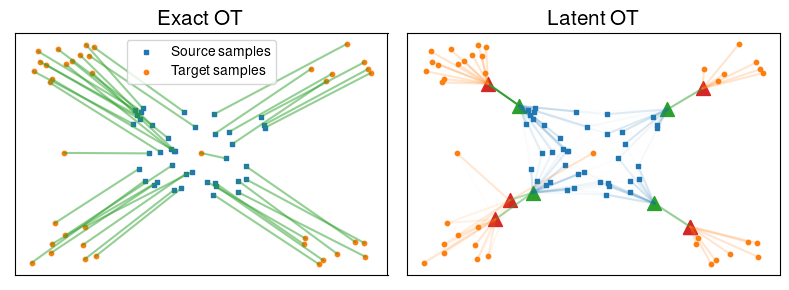

In [477]:
# with LOT

pl.figure(2, (8, 3))

s2 = 10
s = 500

#-------Exact OT
pl.subplot(1, 2, 1)
ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Exact OT',  fontsize = 15)

#-------Latent OT
pl.subplot(1,2,2)
s2 = 100
s = 10
n_source_anchors = 4
n_target_anchors = 6
eps = 5
from lot import LOT

lot = LOT(n_source_anchors= n_source_anchors, n_target_anchors= n_target_anchors, epsilon=eps, epsilon_z=eps)
lot.fit(xs, xt)
lot.Cx.shape, lot.Cy.shape, lot.Px_
print(lot.Py_.shape)
print(lot.Cx.shape)
print(lot.Cx)

ot.plot.plot2D_samples_mat(lot.Cx, lot.Cy, lot.Pz_, c='C2')
ot.plot.plot2D_samples_mat(xs, lot.Cx, lot.Px_, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, lot.Cy, lot.Py_.T, c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], facecolor=None, edgecolors='C0',label="$\mu_1$",s=s, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolor=None, edgecolors='C1',label="$\mu_2$",s=s)
pl.scatter(lot.Cx[:, 0], lot.Cx[:, 1],  c='C2',label="$\mu_1$",s=s2, marker="^")
pl.scatter(lot.Cy[:, 0], lot.Cy[:, 1], c='C3',label="$\mu_2$",s=s2, marker="^")
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('Latent OT',  fontsize = 15)


# Figure 4: Illustration of robustness on some Gaussian distributions

In [101]:
n = 100  # nb samples
n_noise = 25 # noise on the target distribution only

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])
mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n + n_noise, mu_s, cov_s) #n+n_noise samples for the source distribution
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t) # n samples for the target distribution 

#add some noise on the target distribution only
xt = np.concatenate((xt, np.random.rand(n_noise, 2) * 20 - 8)) # and add some noisy samples on the target distribution only

a, b = np.ones((n+n_noise,)) / (n+n_noise), np.ones((n+n_noise,)) / (n+n_noise) # uniform distribution on samples
# cost matrix
C = ot.dist(xs, xt)


In [411]:
#------------OT
G0 = ot.emd(a, b, C)
cost_emd = ot.emd2(a, b, C)

overall_p = 2
X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

Cx, Cy = torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t, b_t = torch.ones((n+n_noise,)) / (n+n_noise), torch.ones((n+n_noise,)) / (n+n_noise)
C_t = ot.dist(X, Y)

#------------factored coupling #useless here as we target anomaly detection
Ga, Gb, xb = ot.factored_optimal_transport(xs, xt, a, b, r=10)
cost_factored_coupling = np.sum(C * Ga.dot(Gb)) * 10

#------------partial OT
Pot = ot.partial.partial_wasserstein(np.ones(n+n_noise)*(n/(n+n_noise))/(n+n_noise), np.ones(n+n_noise)/(n+n_noise), C, n/(n+n_noise))
cost_Pot = ot.partial.partial_wasserstein2(a, b, C, n/(n+n_noise))
print(f"mass transported with the TV penalty: {np.sum(Pot):.2f}")

#------------kl penalty
P_kl = ot.unbalanced.mm_unbalanced(a, b, C, 70, div='kl')
pi1_kl = P_kl@np.ones((n+n_noise))
pi2_kl = (P_kl.T)@np.ones((n+n_noise))
print(f"mass transported with the KL penalty: {np.sum(P_kl):.2f}")

#------------HROT (exact)
lam = 1
P, Qx, Qy = UOT_W(a_t, b_t, C_t, lam=lam, Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)
a_W = P@np.ones((n+n_noise))
b_W = (P.T)@np.ones((n+n_noise))

#delete samples from the P matrix that have low mass
threshold = 3/(n)
sketches_y = np.sum(P, axis=0) 
print(f"nb of sketches transported with OT penalty: {np.sum(sketches_y >(1/n))}")
mass_samples_x = np.sum(P,axis=1).dot(Qx)*(n+n_noise)
mass_samples_y = np.sum(P,axis=0).dot(Qy)*(n+n_noise)

pos_nominal_y = np.where(mass_samples_y > threshold)[0]
pos_outliers_y = np.where(mass_samples_y <= threshold)[0]


#------------HROT (sinkhorn solver)
P_sin, Qx_sin, Qy_sin = logsinkhorn(a_t, b_t, C_t, lam=.25, eps2=2, eps= 2, numiter=30, pen="sinkhorn", Cx = ot.dist(X, X), Cy = ot.dist(Y, Y), numiter2=10, innerplan=True)
P_sin = P_sin.numpy()
Qx_sin = Qx_sin.numpy()
Qy_sin = Qy_sin.numpy()

threshold = 1/(n+n_noise)
sketches_y_sin = np.sum(P_sin, axis=0) 
print(f"nb of sketches transported with OT penalty (sinkhorn): {np.sum(sketches_y_sin >(1/n))}")
mass_samples_x_sin = np.sum(P_sin,axis=1).dot(Qx_sin)*(n+n_noise)
mass_samples_y_sin = np.sum(P_sin,axis=0).dot(Qy_sin)*(n+n_noise)

pos_nominal_y_sin = np.where(mass_samples_y_sin > threshold)[0]
pos_outliers_y_sin = np.where(mass_samples_y_sin <= threshold)[0]
print(len(pos_outliers_y_sin), len(pos_nominal_y_sin))
print(pos_outliers_y_sin)




mass transported with the TV penalty: 0.80
mass transported with the KL penalty: 0.81
nb of sketches transported with OT penalty: 13
nb of sketches transported with OT penalty (sinkhorn): 16
30 95
[  1   5  19  22  28  34  43  63  68  70  72  74  85  87  90  98 102 104
 106 107 108 112 113 115 118 120 121 122 123 124]


-2.31209862528339e-09
nb of sketches transported with OT penalty: 0


([], [])

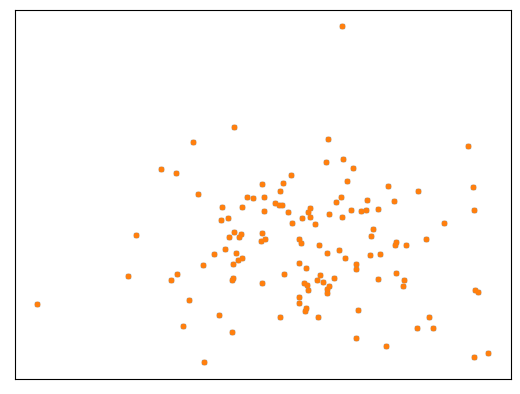

In [422]:
lam = 1
P, Qx, Qy = UOT_W(a_t, b_t, Cx, lam=lam, Cx=Cx,Cy=Cx,solver="CLARABEL", innerplan = True)
a_W = P@np.ones((n+n_noise))
b_W = (P.T)@np.ones((n+n_noise))
print(np.sum(P*Cx.numpy()))

#delete samples from the P matrix that have low mass
threshold = 3/(n)
sketches_y = np.sum(P, axis=0) 
print(f"nb of sketches transported with OT penalty: {np.sum(sketches_y >(1/n))}")
mass_samples_x = np.sum(P,axis=1).dot(Qx)*(n+n_noise)
mass_samples_y = np.sum(P,axis=0).dot(Qy)*(n+n_noise)

pos_nominal_y = np.where(mass_samples_y > threshold)[0]
pos_outliers_y = np.where(mass_samples_y <= threshold)[0]

ot.plot.plot2D_samples_mat(xs, xs, P, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xs[pos_outliers_y, 0], xs[pos_outliers_y, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xs[pos_nominal_y, 0], xs[pos_nominal_y, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)

pl.xticks([])
pl.yticks([])

# s2 = 10
# s = 500
# ot.plot.plot2D_samples_mat(xs, xt, P_sin, c='C2', alpha=1)
# #ot.plot.plot2D_samples_mat(xs, xs, Qx_sin, c='C0', alpha=0.2)
# ot.plot.plot2D_samples_mat(xt, xt, Qy_sin, c='C21', alpha=0.2)

# pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
# #outliers
# pl.scatter(xt[pos_outliers_y_sin, 0], xt[pos_outliers_y_sin, 1], c='C1',s=s2, label='outliers')
# #nominal
# pl.scatter(xt[pos_nominal_y_sin, 0], xt[pos_nominal_y_sin, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)

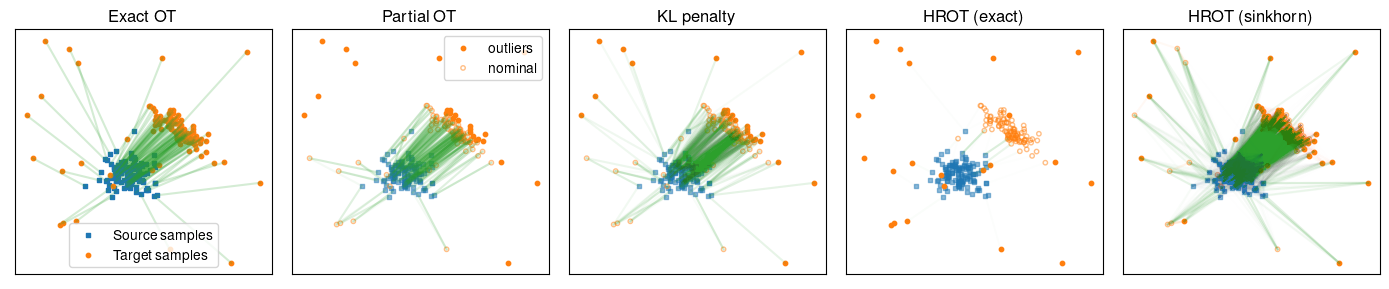

In [390]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
pl.figure(2, (14, 3))

s2 = 10
s = 500
pl.subplot(1, 5, 1)
ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.2)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()

pl.title('Exact OT')


#-------Partial OT
pl.subplot(1, 5, 2)
ot.plot.plot2D_samples_mat(xs, xt, Pot, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xt[np.sum(Pot, 0) < 1e-5, 0], xt[np.sum(Pot, 0) < 1e-5, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[np.sum(Pot, 0) >= 1e-5, 0], xt[np.sum(Pot, 0) >= 1e-5, 1], facecolors='none', edgecolors='C1',s=s2, label='nominal', alpha=0.5)
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Partial OT')

#-------KL penalty OT
pl.subplot(1, 5, 3)
ot.plot.plot2D_samples_mat(xs, xt, P_kl, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
thres_out_kl = np.quantile(np.sum(P_kl, 0), 0.2)
pl.scatter(xt[np.sum(P_kl, 0) < thres_out_kl, 0], xt[np.sum(P_kl, 0) < thres_out_kl, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[np.sum(P_kl, 0) >= thres_out_kl, 0], xt[np.sum(P_kl, 0) >= thres_out_kl, 1], facecolors='none', edgecolors='C1',s=s2, label='nominal', alpha=0.5)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('KL penalty')

#-------HROT (exact)
pl.subplot(1, 5, 4)

ot.plot.plot2D_samples_mat(xs, xt, P, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xt[pos_outliers_y, 0], xt[pos_outliers_y, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[pos_nominal_y, 0], xt[pos_nominal_y, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)

pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (exact)')

#-------HROT (sinkhorn)
pl.subplot(1, 5, 5)

ot.plot.plot2D_samples_mat(xs, xt, P_sin, c='C2', alpha=0.2)
ot.plot.plot2D_samples_mat(xs, xs, Qx_sin, c='C0', alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy_sin, c='C21', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xt[pos_outliers_y_sin, 0], xt[pos_outliers_y_sin, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[pos_nominal_y_sin, 0], xt[pos_nominal_y_sin, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)

pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (sinkhorn)')


# pl.subplot(1, 6, 5)
# ot.plot.plot2D_samples_mat(xs, xt, P_thres, c='C2')
# ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=1)
# ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=1)

# pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=a_W*s, marker= "s")
# pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
# pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
# pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
# pl.xticks([])
# pl.yticks([])
# pl.tight_layout()
# pl.title('HROT (thresholded)')

# pl.subplot(1, 6, 6)
# #ot.plot.plot2D_samples_mat(xs, xt, P_thres, c='C2')
# #ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=1)
# #ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=1)

# thres = 2
# pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=(Qx_mass<thres)*s/100, marker= "s")
# pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=(Qy_mass<thres)*s/100)

# #pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
# #pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
# pl.xticks([])
# pl.yticks([])
# pl.tight_layout()
# pl.title('HROT (thresholded+removed)')




pl.savefig("illustration_with_noise.pdf",bbox_inches='tight')




In [9]:

#pl.imshow(Qy)
#pl.show()
print(np.sum(Qx_mass<thres))
Qx_zero = Qy.copy()
Qx_zero[Qx_zero < 1e-5] = 0

mass_clusters_x = np.round(np.sum(Qx_zero, 1)*(n+n_noise),0)
Qx_mass = mass_clusters_x[np.nonzero(Qx_zero.T)[1]]
Qx_mass
#np.where(Qx >= (1/200))



42


array([ 8.,  1.,  3.,  3.,  1.,  2.,  3.,  2.,  8.,  1.,  3.,  8.,  4.,
        4.,  3.,  5.,  2.,  1.,  1.,  3.,  1.,  3.,  3., 13.,  3.,  2.,
        3.,  9.,  1.,  9.,  9.,  5., 13.,  3.,  3.,  4., 13., 13.,  2.,
        8.,  4.,  1.,  4.,  4.,  3.,  2.,  1.,  1., 13.,  9., 13., 13.,
        1.,  2., 13.,  1.,  8., 13.,  1.,  9.,  1.,  4., 13.,  4., 13.,
        3.,  5.,  4.,  9.,  3., 13.,  9.,  5.,  4., 13.,  8.,  8.,  3.,
        4.,  1.,  9.,  1.,  5.,  4.,  1.,  3.,  4.,  3.,  2.,  3.,  2.,
        8.,  9.,  1.,  4.,  3.,  4.,  1.,  3.,  2.,  1.,  1.,  4.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [302]:
np.sum(P_kl, 0)
np.quantile(np.sum(P_kl, 0), 0.2)



0.006000373425667971

# Illustration on Gaussian distributions with noise only on 1 distribution

In [10]:
n = 100  # nb samples
n_noise = 20

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

#compute the true W

cov_s_sqrt = sqrtm(cov_s)
bures = np.trace(-2 * sqrtm(np.dot(cov_s_sqrt, cov_t, cov_s_sqrt)) + cov_s + cov_t)
true_W_no_noise = np.sum((mu_s - mu_t)**2) + bures
print(true_W_no_noise)


xs = ot.datasets.make_2D_samples_gauss(n + n_noise, mu_s, cov_s) #n+n_noise samples for the source distribution
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t) # n samples for the target distribution 

M = ot.dist(xs, xt)
emp_W_no_noise = ot.emd2([], [], M)
print("empirical W", emp_W_no_noise, " and true one ", true_W_no_noise)

#add some noise
#xs = np.concatenate((xs, np.random.rand(n_noise, 2)*20-8))
xt = np.concatenate((xt, np.random.rand(n_noise, 2)*20-8)) # and add some noisy samples on the target distribution only

a, b = np.ones((n+n_noise,)) / (n+n_noise), np.ones((n+n_noise,)) / (n+n_noise) # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)




32.42229123600033
empirical W 32.19037227961723  and true one  32.42229123600033


In [11]:


M = ot.dist(xs, xt)
G0 = ot.emd(a, b, M)
cost_emd = ot.emd2(a, b, M)

C=ot.dist(xs,xt)

overall_p = 2

X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

Cx,Cy=torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t,b_t=torch.ones((n+n_noise,)) / (n+n_noise), torch.ones((n+n_noise,)) / (n+n_noise)

#factored coupling
Ga, Gb, xb = ot.factored_optimal_transport(xs, xt, a, b, r=10)
cost_factored_coupling = np.sum(M*Ga.dot(Gb)) * 10

lam = 2
P, Qx, Qy = UOT_W(a_t,b_t,C,lam=lam, Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)
a_W=P@np.ones((n+n_noise))
b_W=(P.T)@np.ones((n+n_noise))

cost_UOT_complete = np.sum(P*M) + np.sum(Qx * Cx.numpy()) + np.sum(Qy * Cy.numpy())

#delete low mass clusters

Qx_zero = Qx.copy()
Qx_zero[Qx_zero < 1e-5] = 0
nb_cluster_x = np.sum(np.round(np.sum(Qx_zero, 1)*(n),0) >0)
mass_clusters_x = np.round(np.sum(Qx_zero, 1)*(n),0)
Qx_mass = mass_clusters_x[np.nonzero(Qx_zero.T)[1]]

Qy_zero = Qy.copy()
Qy_zero[Qy_zero < 1e-5] = 0
nb_cluster_y = np.sum(np.round(np.sum(Qy_zero, 0)*(n+n_noise),0) >0)
mass_clusters_y = np.round(np.sum(Qy_zero, 1)*(n+n_noise),0)
Qy_mass = mass_clusters_y[np.nonzero(Qy_zero.T)[1]]


threshold = 0.009
print(np.max(P), np.min(P[P>1e-5]))
a_W_threshold = a_W.copy()
a_W_threshold[a_W_threshold < threshold] = 0
a_W_threshold_inv = a_W.copy()
a_W_threshold_inv[a_W_threshold >= threshold] = 0
b_W_threshold = b_W.copy()
b_W_threshold[b_W_threshold < threshold] = 0
b_W_threshold_inv = b_W.copy()
b_W_threshold_inv[b_W_threshold >= threshold] = 0
P_thres = P.copy()
P_thres[a_W_threshold < threshold] = 0
P_thres[:,b_W_threshold < threshold] = 0
cost_UOT_threshold = np.sum(P_thres*M) + np.sum(Qx * Cx.numpy()) + np.sum(Qy * Cy.numpy())

#partial OT
Pot = ot.partial.partial_wasserstein(np.ones(n+n_noise)*(n/(n+n_noise))/(n+n_noise), np.ones(n+n_noise)/(n+n_noise),M, n/(n+n_noise))
cost_Pot = ot.partial.partial_wasserstein2(a,b,M, n/(n+n_noise))





0.08333328849874815 0.008333286198193434


/Applications/anaconda3/envs/python_GPU/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


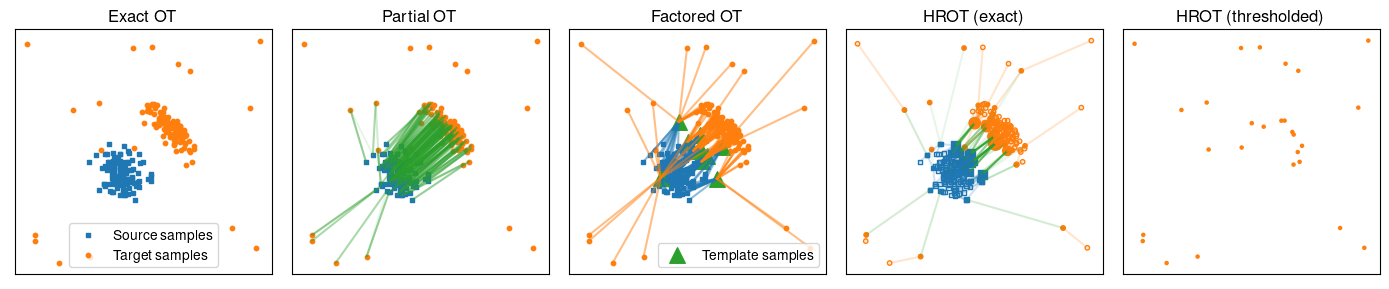

In [12]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
pl.figure(2, (14, 3))

s2 = 10
s = 500
pl.subplot(1, 5, 1)
#ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()

pl.title('Exact OT')

pl.subplot(1, 5, 3)
ot.plot.plot2D_samples_mat(xs, xb, Ga, c='C0', alpha=0.5)
ot.plot.plot2D_samples_mat(xb, xt, Gb, c='C1', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2)
pl.scatter(xb[:, 0], xb[:, 1], c='C2',s=int(500/4), label='Template samples', marker="^")
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Factored OT')

pl.subplot(1, 5, 4)
ot.plot.plot2D_samples_mat(xs, xt, P, c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=a_W*s, marker= "s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (exact)')

pl.subplot(1, 5, 5)
#ot.plot.plot2D_samples_mat(xs, xt, P_thres, c='C2')
#ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=1)
#t.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=1)

thres = 4
#pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=(Qx_mass<thres)*s/100, marker= "s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=(Qy_mass<thres)*s/100)
#pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
#pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (thresholded)')

pl.subplot(1, 5, 2)
ot.plot.plot2D_samples_mat(xs, xt, Pot,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])




pl.tight_layout()

pl.title('Partial OT')


pl.savefig("illustration_with_noise_on_target_only.pdf",bbox_inches='tight')




In [13]:
print(nb_cluster_x, nb_cluster_y)

26 120


# Now, with sinkhorn




(120, 120) <class 'numpy.ndarray'>
2
(5626,)
(120, 120) (120,) (5626,) (5626,)


/Applications/anaconda3/envs/python_GPU/lib/python3.8/site-packages/ot/plot.py:95: RuntimeWarning: invalid value encountered in float_scalars
  if G[i, j] / mx > thr:


ValueError: s must be a scalar, or float array-like with the same size as x and y

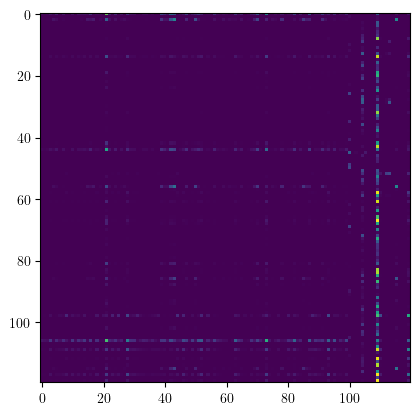

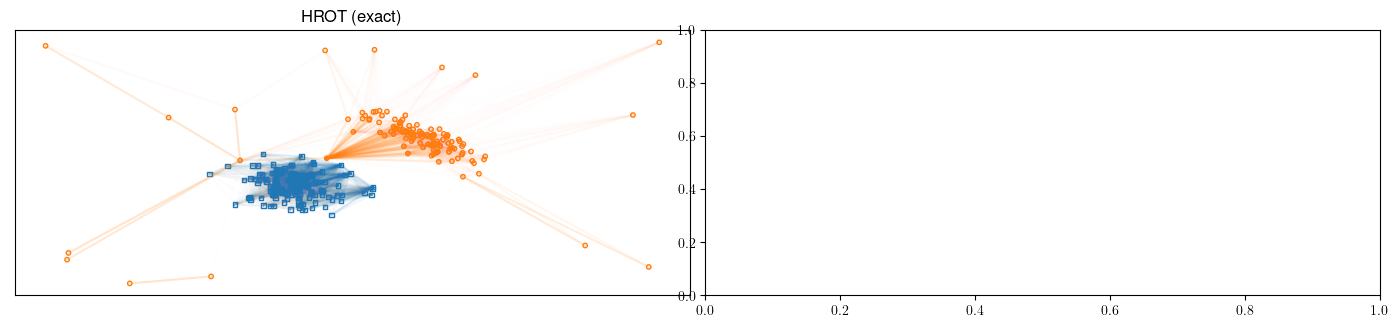

In [55]:
from sinkhorn_iterates import sinkhorn

M = ot.dist(X, Y)
P_s, Qx_s, Qy_s = sinkhorn(a_t, b_t, M, lam=1e1, eps= 2, numiter=30, pen="sinkhorn", Cx = ot.dist(X, X), Cy = ot.dist(Y, Y), numiter2=10, innerplan=True)
pl.imshow(P_s)

Qx_zero_s = Qx.numpy()
Qx_zero_s[Qx_zero_s < 1e-5] = 0
nb_cluster_x = np.sum(np.round(np.sum(Qx_zero_s, 1)*(n),0) >0)
mass_clusters_x = np.round(np.sum(Qx_zero_s, 1)*(n),0)
Qx_mass = mass_clusters_x[np.nonzero(Qx_zero_s.T)[1]]

Qy_zero_s = Qy.numpy()
Qy_zero_s[Qy_zero_s < 1e-5] = 0
nb_cluster_y = np.sum(np.round(np.sum(Qy_zero_s, 0)*(n+n_noise),0) >0)
mass_clusters_y = np.round(np.sum(Qy_zero_s, 1)*(n+n_noise),0)
Qy_mass = mass_clusters_y[np.nonzero(Qy_zero_s.T)[1]]


print(Qy_zero_s.shape, type(Qy_zero_s))
rr = np.nonzero(Qy_zero_s.T)
print(len(rr))
print(np.nonzero(Qy_zero_s.T)[0].shape)
print(Qy_zero_s.shape, mass_clusters_y.shape, Qy_mass.shape, np.nonzero(Qy_zero_s.T)[1].shape)


a_W=P@np.ones((n+n_noise))
b_W=(P.T)@np.ones((n+n_noise))

threshold = 0.009
#print(torch.max(P), torch.min(P[P>1e-5]))
a_W_threshold = a_W
a_W_threshold[a_W_threshold < threshold] = 0
a_W_threshold_inv = a_W
a_W_threshold_inv[a_W_threshold >= threshold] = 0
b_W_threshold = b_W
b_W_threshold[b_W_threshold < threshold] = 0
b_W_threshold_inv = b_W
b_W_threshold_inv[b_W_threshold >= threshold] = 0
P_thres = P
P_thres[a_W_threshold < threshold] = 0
P_thres[:,b_W_threshold < threshold] = 0
cost_UOT_threshold = torch.sum(P_thres*M) + torch.sum(Qx * Cx) + torch.sum(Qy * Cy)
cost_UOT_threshold

pl.figure(3, (14, 3))
pl.subplot(1, 2, 1)
ot.plot.plot2D_samples_mat(xs, xt, P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy.numpy(), c='C1',alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=a_W*s, marker= "s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (exact)')

pl.subplot(1, 2, 2)
thres = 4
#pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=(Qx_mass<thres)*s/100, marker= "s")
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=(Qy_mass<thres)*s/100)
#pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2, marker="s")
#pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('HROT (thresholded)')


# an other example with 1 outlier in the middle



In [10]:
n = 100  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([10, 4])
cov_t = np.array([[1, 0], [0, 1]])


xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
xt[0, 0] = 0
xt[1, 0] = 5 

C=ot.dist(xs,xt)

overall_p = 2

X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

Cx,Cy=torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t,b_t=torch.ones((n+n_noise,)) / (n+n_noise), torch.ones((n+n_noise,)) / (n+n_noise)


lam = 10
P, Qx, Qy = UOT_W(a_t,b_t,C,lam=lam, Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)

ValueError: Cannot broadcast dimensions  (100,) (120,)

In [ ]:
s = 500
s2 = 10
pl.figure(figsize=(3,3))
ot.plot.plot2D_samples_mat(xs, xt, P, c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=0.2)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)
pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=a_W*s)
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2)
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.savefig("cluster_factored_couping.pdf",bbox_inches='tight')

In [ ]:
#GROT
u,v,G,Qx,Qy=sinkhorn(a_t.float(),b_t.float(),torch.tensor(C).float(),lam=.1,eps=.5,numiter=500,pen="sinkhorn",
               Cx=Cx.float(),Cy=Cy.float(),numiter2=10,innerplan=True)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)

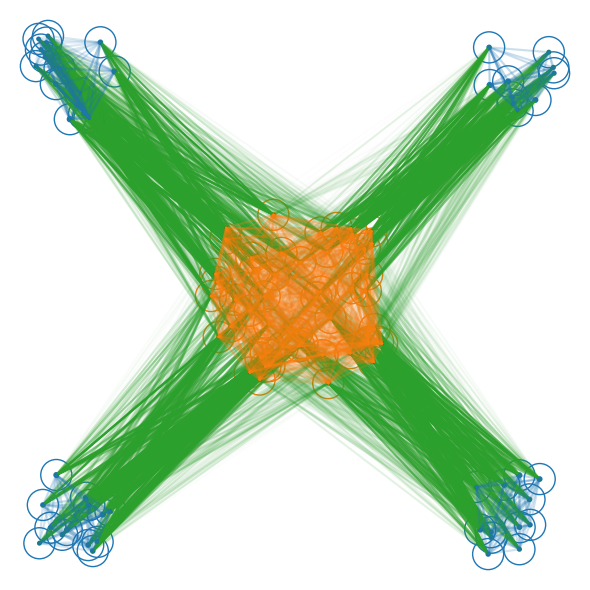

In [ ]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X, Y, P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X, X, Qx.numpy(), c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(Y, Y, Qy.numpy(), c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], c='C0',s=a_W*s)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',s=b_W*s)
#pl.scatter(X[:, 0], X[:, 1], c='C0',alpha=0.2)
#pl.scatter(Y[:, 0], Y[:, 1], c='C1',alpha=0.2)
pl.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='C0',label="$\mu_1$",s=s)
pl.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s)
#label6 = Line2D([0], [0], label="$\mu_1$", marker='o', color='C0', linestyle='',alpha=0.2)
#label7 = Line2D([0], [0], label="$\mu_2$", marker='o', color='C1', linestyle='',alpha=0.2)
pl.axis('off')
pl.tight_layout()

# Change the dimension

In [ ]:
# parameters and data generation (from POT)

np.random.seed(42)
dim = 30
n = 50  # nb samples
xs = np.random.rand(n, dim) - .5
xt = xs + 2*np.sign(xs)
#xt = np.random.rand(n, dim) - .5
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

#compute transports
C=ot.dist(xs,xt)
G0 = ot.emd(a, b, C)

X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

overall_p = 3
Cx,Cy=torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t,b_t=torch.ones((n,))/n,torch.ones((n,))/n

#factored coupling
Ga, Gb, xb = ot.factored_optimal_transport(xs, xt, a, b, r=4)
#GROT
P, Qx, Qy = UOT_W(a_t,b_t,C,lam=.03, Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)


print(np.sum(P))
print(np.sum(P*C))


0.9999999776473011
119.99999727903857


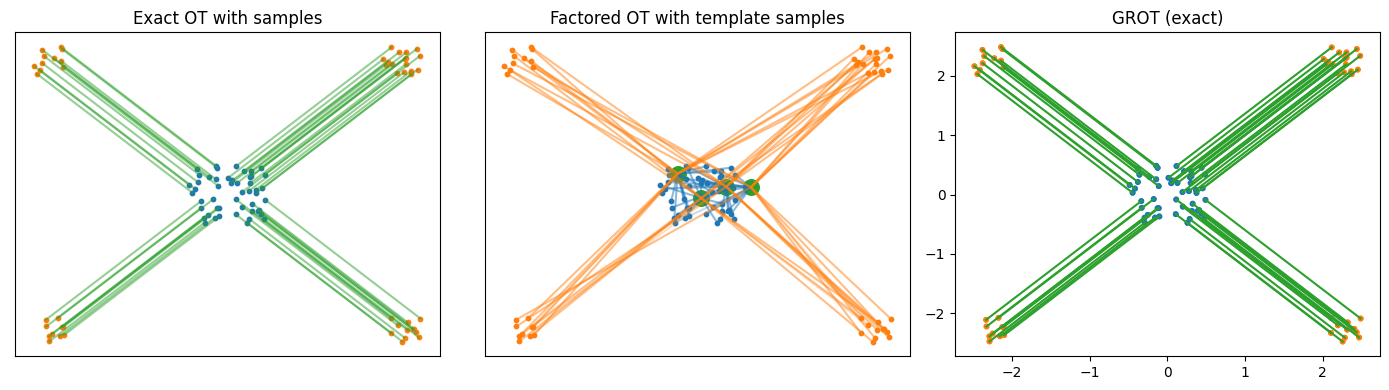

In [ ]:
pl.figure(2, (14, 4))

s2 = 10
s = 500
pl.subplot(1, 3, 1)
ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1],  c='C0',s=s2, label='Source samples')
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('Exact OT with samples')

pl.subplot(1, 3, 2)
ot.plot.plot2D_samples_mat(xs, xb, Ga, c='C0', alpha=0.5)
ot.plot.plot2D_samples_mat(xb, xt, Gb, c='C1', alpha=0.5)
pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, label='Source samples')
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=s2, label='Target samples')
pl.scatter(xb[:, 0], xb[:, 1], c='C2',s=int(500/4), label='Template samples')
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('Factored OT with template samples')

pl.subplot(1, 3, 3)
ot.plot.plot2D_samples_mat(xs, xt, P, c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=0.2)
ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=0.2)
a_W=P@np.ones(n)
b_W=(P.T)@np.ones(n)
pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=a_W*s)
pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
pl.scatter(xs[:, 0], xs[:, 1],  facecolors='none', edgecolors='C0',label="$\mu_1$",s=s2)
pl.scatter(xt[:, 0], xt[:, 1], facecolors='none', edgecolors='C1',label="$\mu_2$",s=s2)
#pl.xticks([])
#pl.yticks([])
pl.tight_layout()
pl.title('GROT (exact)')

pl.savefig("comp_with_factored_couplings.pdf",bbox_inches='tight')




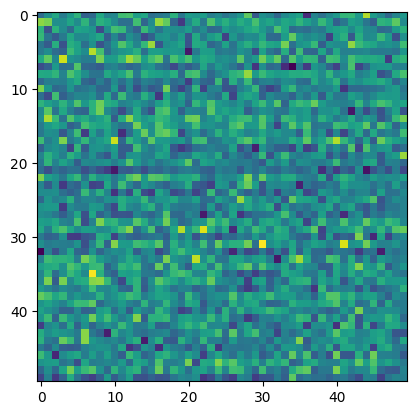

In [ ]:
pl.imshow(C)

# plots about factored couplings

## change the number of clusters

overall EMD 8.000000000000005


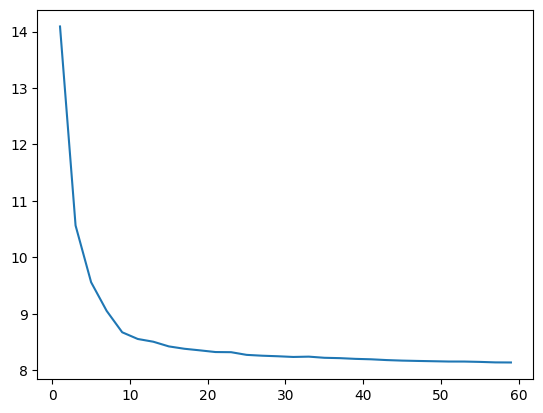

In [ ]:
# parameters and data generation (from POT)

np.random.seed(42)
n = 1000  # nb samples

dim = 3
xs = (np.random.rand(n, dim) - .5)*2
xt = xs + 2*np.sign(xs)
xt[:,2:] = xs[:,2:]
#xt = np.random.rand(n, 2) - .5
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

M = ot.dist(xs, xt)
G0 = ot.emd(a, b, M)
print("overall EMD", np.sum(G0*M))

l_cost = []
for r in range(1,60,2):
    #factored coupling
    Ga, Gb, xb= ot.factored_optimal_transport(xs, xt, a, b, r=r)

    ot_cost = np.sum(M*Ga.dot(Gb))*r
    l_cost.append(ot_cost)

pl.plot(list(range(1,60,2)), l_cost)


## change the dimension of the samples

overall EMD 8.000000000000005


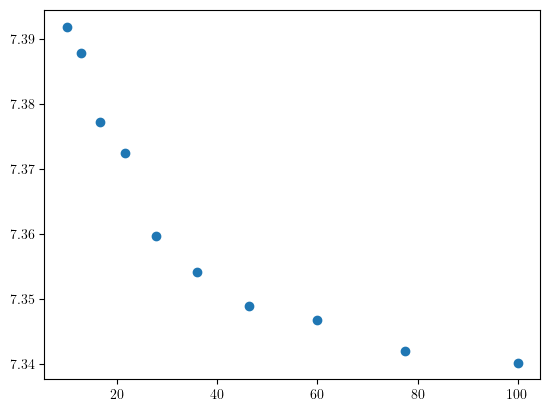

In [11]:
# parameters and data generation (from POT)

np.random.seed(42)
n = 1000  # nb samples
dim  =2
xs = (np.random.rand(n, dim) - .5)*2
xt = xs + 2*np.sign(xs)
#xt[:,2:] = xs[:,2:]
#xt = np.random.rand(n, 2) - .5
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

M = ot.dist(xs, xt)
G0 = ot.emd(a, b, M)
print("overall EMD", np.sum(G0*M))

l_cost = []
l_emd_cost = []
r = 4
for dim in np.logspace(1, 2, 10):
    d = int(dim)
    n = 10 * d
    xs = (np.random.rand(n, d) - .5)*2
    xt = xs + 2*np.sign(xs)
    #xt[:,2:] = xs[:,2:]
    
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

    M = ot.dist(xs, xt)
    G0 = ot.emd(a, b, M)
    l_emd_cost.append(np.sum(G0*M))

    #factored coupling
    Ga, Gb, xb= ot.factored_optimal_transport(xs, xt, a, b, r=r)

    ot_cost = np.sum(M*Ga.dot(Gb)) * r / (10*d)
    l_cost.append(ot_cost)

pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_cost)-8))
#pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_emd_cost)-8))
pl.show()


## change the number of samples

overall EMD 119.99999999999973


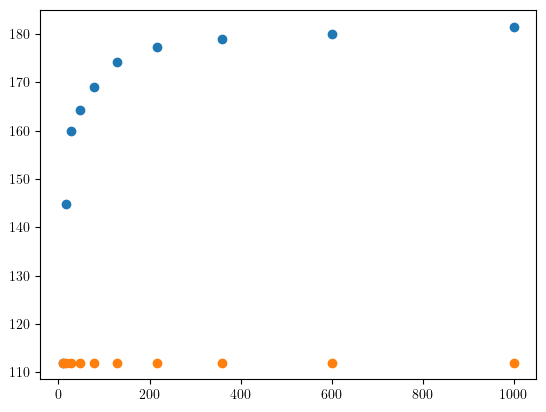

In [12]:
# parameters and data generation (from POT)

np.random.seed(42)
n = 1000  # nb samples
dim  = 30
xs = (np.random.rand(n, dim) - .5)*2
xt = xs + 2*np.sign(xs)
#xt[:,2:] = xs[:,2:]
#xt = np.random.rand(n, 2) - .5
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

M = ot.dist(xs, xt)
G0 = ot.emd(a, b, M)
print("overall EMD", np.sum(G0*M))

l_cost = []
l_emd_cost = []
r = 10
for n in np.logspace(1, 3, 10):
    d = dim
    n = int(n)
    xs = (np.random.rand(int(n), d) - .5)*2
    xt = xs + 2*np.sign(xs)
    
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

    M = ot.dist(xs, xt)
    G0 = ot.emd(a, b, M)
    l_emd_cost.append(np.sum(G0*M))

    #factored coupling
    Ga, Gb, xb= ot.factored_optimal_transport(xs, xt, a, b, r=r)

    ot_cost = np.sum(M*Ga.dot(Gb)) * r 
    l_cost.append(ot_cost)

pl.scatter(np.logspace(1, 3, 10), np.abs(np.array(l_cost)-8))
pl.scatter(np.logspace(1, 3, 10), np.abs(np.array(l_emd_cost)-8))
pl.show()


# plots about GROT

In [13]:

# parameters and data generation (from POT)

np.random.seed(42)


l_cost = []
l_emd_cost = []
r = 4
for dim in np.logspace(1, 2, 10):
    print(dim)
    d = int(dim)
    n = 10 * d
    xs = (np.random.rand(n, d) - .5)*2
    xt = (np.random.rand(n, d) - .5)*2
    xt = xt + 2*np.sign(xs)
    xt2 = (np.random.rand(n, d) - .5)*2
    xt[:,2:] = xt2[:,2:]


    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

    M = ot.dist(xs, xt)
    G0 = ot.emd(a, b, M)
    l_emd_cost.append(np.sum(G0*M))

    X = torch.from_numpy(xs).float()
    Y = torch.from_numpy(xt).float()


   
    Cx,Cy=torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
    Cx, Cy = Cx**overall_p, Cy**overall_p
    a_t,b_t=torch.ones((n,))/n,torch.ones((n,))/n

    #factored coupling
    #Ga, Gb, xb= ot.factored_optimal_transport(xs, xt, a, b, r=r)
    #GROT
    P, Qx, Qy = UOT_W(a_t,b_t,M,lam=.3*np.log(dim), Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)
    a_W=P@np.ones(n)
    b_W=(P.T)@np.ones(n)

    
    ot_cost = np.sum(P*M)
    l_cost.append(ot_cost)

pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_cost)-8))
pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_emd_cost)-8))
pl.xscale('log')
pl.yscale('log')
pl.show()




10.0
12.91549665014884
16.68100537200059
21.544346900318832
27.825594022071243
35.938136638046274


KeyboardInterrupt: 

In [ ]:
l_cost
#pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_cost)-8))
#pl.scatter(np.logspace(1, 2, 10), np.abs(np.array(l_emd_cost)-8))


[4.730193243976164,
 5.548182712198521,
 8.140899534640285,
 11.207086024977826,
 14.450820714030982,
 18.263732004933278,
 23.695791487183335,
 30.499575738754086,
 39.82891512372596,
 52.07177999884817]

In [ ]:
for dim in np.logspace(1, 2, 10):
    d = int(dim)
    n = 10 * d
    xs = (np.random.rand(n, d) - .5)*2
    xt = xs + 2*np.sign(xs)
    xt[:,2:] = xs[:,2:]
    #xt = np.random.rand(n, 2) - .5
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples
    a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

    #M = ot.dist(xs, xt)

    #factored coupling
    Ga, Gb, xb= ot.factored_optimal_transport(xs, xt, a, b, r=r)

    ot_cost = np.sum(M*Ga.dot(Gb)) * r
    l_cost.append(ot_cost)

ValueError: operands could not be broadcast together with shapes (1000,1000) (100,100) 

In [116]:
np.sum(Ga.dot(Gb), axis=0)
np.sum(Ga.dot(Gb)) * 4 

0.9999999999999978

In [75]:
l_cost

[2104.5001370254404,
 1408.0183233894163,
 1030.8361461948398,
 823.1452581678865,
 679.518029332217,
 582.5095130700024,
 506.7542408239466,
 450.03861735080443,
 404.3747926878603,
 367.3952470814482,
 336.51487549704365,
 310.4020767708563,
 288.2731111766864,
 268.6015802108401,
 251.6797568021192,
 236.7323947744179,
 223.54602331214483,
 211.75516108599368,
 201.107594447613,
 191.35146403207224,
 182.7181052240565,
 174.64010227022584,
 167.64041317621076,
 160.59039079852678,
 154.42492376959606,
 148.62402300946923,
 143.3405423350645,
 138.34849597525107]